In [1]:
!pip install keras_cv

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os

Using TensorFlow backend


## Data Pipeline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# dataset_location = './Food ingredient recognition.v4i.tfrecord'
# dataset_location = './drive/MyDrive/Food ingredient recognition.v4i.tfrecord' # Google Colab
dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord" # Punya Andi
tfrecord_name = "food-ingredient.tfrecord"
print(os.path.exists(dataset_location))

True


In [5]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
dataset_validation = tf.data.TFRecordDataset(dataset_location + f"/validation/{tfrecord_name}")

In [6]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [7]:
from keras_cv import bounding_box
from keras_cv import visualization

class_ids = [
    "-",
    "almond",
    "apple",
    "avocado",
    "beef",
    "bell pepper",
    "blueberry",
    "bread",
    "broccoli",
    "butter",
    "carrot",
    "cheese",
    "chilli",
    "cookie",
    "corn",
    "cucumber",
    "egg",
    "eggplant",
    "garlic",
    "lemon",
    "milk",
    "mozarella cheese",
    "mushroom",
    "mussel",
    "onion",
    "oyster",
    "parmesan cheese",
    "pasta",
    "pork rib",
    "potato",
    "salmon",
    "scallop",
    "shrimp",
    "strawberry",
    "toast bread",
    "tomato",
    "tuna",
    "yogurt",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = np.array(image)
    inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image = inference_resizing([image])
    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xywh',
        y_pred=bounding_boxes
    )

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

validation_augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        )
    ]
)

{'images': <tf.Tensor 'args_2:0' shape=(4, 640, 640, None) dtype=float32>, 'bounding_boxes': {'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None, None), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(5,), dtype=int64)), 'classes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(5,), dtype=int64))}}


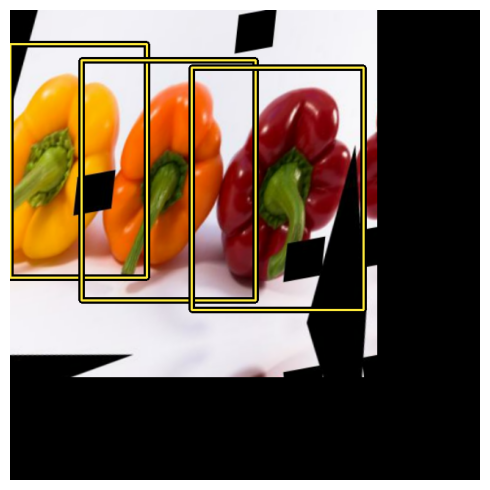

In [8]:
from keras_cv import bounding_box

train_data_initial = dataset_train.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=10_000).ragged_batch(4, drop_remainder=True)
train_data_resized = train_data_initial.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    print(inputs)
    # return tf.RaggedTensor.to_tensor(inputs["images"]), bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

train_data = train_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

for result in train_data.take(1):
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=result[1]
    )


In [9]:
validation_data_initial = dataset_validation.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=10_000).ragged_batch(4, drop_remainder=True)
validation_data_resized = validation_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

{'images': <tf.Tensor 'args_2:0' shape=(4, 640, 640, None) dtype=float32>, 'bounding_boxes': {'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None, None), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(5,), dtype=int64)), 'classes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(5,), dtype=int64))}}


In [10]:
# import keras

# pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
#     "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
# )
# image = keras.utils.load_img("stock-photo-airport-with-many-airplanes-at-beautiful-sunset-324754607.jpg")
# image = np.array(image)
# # print(image.shape)

# visualization.plot_image_gallery(
#     np.array([image]),
#     value_range=(0, 255),
#     rows=1,
#     cols=1,
#     scale=5,)
# inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
# )
# image_batch = inference_resizing([image])
# # print(image_batch)
# class_ids = [
#     "Aeroplane",
#     "Bicycle",
#     "Bird",
#     "Boat",
#     "Bottle",
#     "Bus",
#     "Car",
#     "Cat",
#     "Chair",
#     "Cow",
#     "Dining Table",
#     "Dog",
#     "Horse",
#     "Motorbike",
#     "Person",
#     "Potted Plant",
#     "Sheep",
#     "Sofa",
#     "Train",
#     "Tvmonitor",
#     "Total",
# ]
# # class_mapping = dict(zip(range(len(class_ids)), class_ids))
# # y_pred = pretrained_model.predict(image_batch)

# # print(y_pred)

# for sample in train_data_unbatched.take(1):
#     image = np.array(sample['images'])
#     inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
#     )
#     image = inference_resizing([image])
#     y_pred = pretrained_model.predict(image)
#     print(y_pred)
#     visualization.plot_bounding_box_gallery(
#         image,
#         value_range=(0, 255),
#         rows=1,
#         cols=1,
#         y_pred=y_pred,
#         scale=5,
#         font_scale=0.7,
#         bounding_box_format="xyxy",
#         class_mapping=class_mapping,
#     )


In [11]:
# Get the number of classes in the dataset
# unique_classes = set()
# for parsed_dataset in train_data:
#     classes = parsed_dataset['bounding_boxes']['classes'].numpy()
#     unique_classes.update(np.unique(classes))

# NUM_CLASSES = len(unique_classes)
NUM_CLASSES = len(class_ids)

In [12]:
# Pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    include_rescaling = True,
)

model = keras_cv.models.YOLOV8Detector(
    num_classes=NUM_CLASSES,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [13]:
freeze = 133
# Freeze to up to 133 layers
# for i, layer in enumerate(model.layers):
#     if i < freeze:
#         layer.trainable = False


In [14]:
# class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
#     def __init__(self, data, save_path):
#         super().__init__()
#         self.data = data
#         self.metrics = keras_cv.metrics.BoxCOCOMetrics(
#             bounding_box_format="xyxy",
#             evaluate_freq=1e9,
#         )

#         self.save_path = save_path
#         self.best_map = -1.0

#     def on_epoch_end(self, epoch, logs):
#         self.metrics.reset_state()
#         for batch in self.data:
#             images, y_true = batch[0], batch[1]
#             y_pred = self.model.predict(images, verbose=0)
#             self.metrics.update_state(y_true, y_pred)

#         metrics = self.metrics.result(force=True)
#         logs.update(metrics)

#         current_map = metrics["MaP"]
#         if current_map > self.best_map:
#             self.best_map = current_map
#             self.model.save(self.save_path)  # Save the model when mAP improves

#         return logs

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm = 10.0
)

model.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2


In [ ]:
model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model.pb")

In [ ]:
for result in train_data.take(1):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1]
    )